# Figure 2 script

To reproduce this figure, make sure you have downloaded all necessary input files (velocity maps and static terrain geometries) from https://doi.org/10.17605/OSF.IO/HE7YR and have updated the `Vx` and `Vy` columns in `notebooks/manifest.csv` with the downloaded file paths before starting the analysis.

In [1]:
import glaft
import pandas as pd
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# font and linewidth settings
font = {'size'   : 14}
mpl.rc('font', **font)
axes_settings = {'linewidth'   : 2}
mpl.rc('axes', **axes_settings)

# read and select data
df = pd.read_csv('../manifest.csv', dtype=str)
in_shp = '/home/jovyan/Projects/PX_comparison/shapefiles/bedrock_V2.shp'
selected_cases = df.loc[[126, 130, 134, 97, 73, 28]]
selected_cases

,Date,Duration (days),Template size (px),Template size (m),Pixel spacing (px),Pixel spacing (m),Prefilter,Subpixel,Software,Vx,Vy
126,LS8-20180304-20180405,32,64,960,4,60,None,pyrUP,autoRIFT,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,/home/jovyan/Projects/PX_comparison/PX/autoRIF...
130,LS8-20180304-20180405,32,64,960,4,60,Gau,pyrUP,autoRIFT,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,/home/jovyan/Projects/PX_comparison/PX/autoRIF...
134,LS8-20180304-20180405,32,64,960,4,60,NAOF,pyrUP,autoRIFT,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,/home/jovyan/Projects/PX_comparison/PX/autoRIF...
97,LS8-20180304-20180405,32,65,975,1,15,Gau,parabolic,Vmap,/home/jovyan/Projects/PX_comparison/PX/Vmap/pa...,/home/jovyan/Projects/PX_comparison/PX/Vmap/pa...
73,LS8-20180304-20180405,32,varying: multi-pass,varying: multi-pass,4.009,60.14,NAOF,interest point groups,GIV,/home/jovyan/Projects/PX_comparison/PX/GIV/u_l...,/home/jovyan/Projects/PX_comparison/PX/GIV/v_l...
28,LS8-20180304-20180405,32,64,960,1,15,NAOF,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...


This cell performs the static terrain analysis and calculates the corresponding metrics.

In [3]:
exps = {}

for idx, row in selected_cases.iterrows():
    exp = glaft.Velocity(vxfile=row.Vx, vyfile=row.Vy, static_area=in_shp, 
                         kde_gridsize=60, thres_sigma=2.0)
    exp.static_terrain_analysis()
    exps[idx] = exp

Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Ru

The following functions plot the braces on the axes with annotations, which is necessary for Figure 2. They are modified from guzey's answer to [this StackOverflow thread](https://stackoverflow.com/questions/18386210/annotating-ranges-of-data-in-matplotlib/68180887#68180887).

In [4]:
def draw_brace_x(ax, xspan: tuple=(None, None), yy: float=0.0, text: str=''):
    """
    ax: axes to be drawn.
    xspan: x coordinates of the two brace ending points.
    yy: y coordinate of the two brace ending points. 
        (The brace will be placed horizontally)
    text: annotation text.
    """

    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan / xax_span * 100) * 2 + 1 # sampling resolution of the sigmoid brace
    beta = 200. / xax_span                           # the higher this is, the sharper the sigmoid

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution / 2) + 1]
    y_half_brace = (1 / (1. + np.exp(-beta * (x_half - x_half[0] )))
                  + 1 / (1. + np.exp(-beta * (x_half - x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy - (.05 * y - .01) * yspan                 # adjust vertical stretch and position

    ax.plot(x, y, color='black', lw=1)
    ax.text((xmax + xmin) / 2., yy - .07 * yspan, text, ha='left', va='top')
    
def draw_brace_y(ax, yspan: tuple=(None, None), xx: float=0.0, text: str=''):
    """
    ax: axes to be drawn.
    yspan: y coordinates of the two brace ending points.
    xx: x coordinate of the two brace ending points. 
        (The brace will be placed vertically)
    text: annotation text.
    """

    ymin, ymax = yspan
    yspan = ymax - ymin
    ax_ymin, ax_ymax = ax.get_ylim()
    yax_span = ax_ymax - ax_ymin

    xmin, xmax = ax.get_xlim()
    xspan = xmax - xmin
    resolution = int(yspan / yax_span * 100) * 2 + 1 # sampling resolution of the sigmoid brace
    beta = 200. / yax_span                           # the higher this is, the sharper the sigmoid

    y = np.linspace(ymin, ymax, resolution)
    y_half = y[:int(resolution / 2) + 1]
    x_half_brace = (1 / (1. + np.exp(-beta * (y_half - y_half[0] )))
                  + 1 / (1. + np.exp(-beta * (y_half - y_half[-1]))))
    x = np.concatenate((x_half_brace, x_half_brace[-2::-1]))
    x = xx - (.05 * x - .01) * xspan                 # adjust vertical stretch and position

    ax.plot(x, y, color='black', lw=1)
    ax.text(xx - .05 * xspan, (ymax + ymin) / 2., text, rotation=90, ha='right', va='bottom')

Now starting to make the figure:

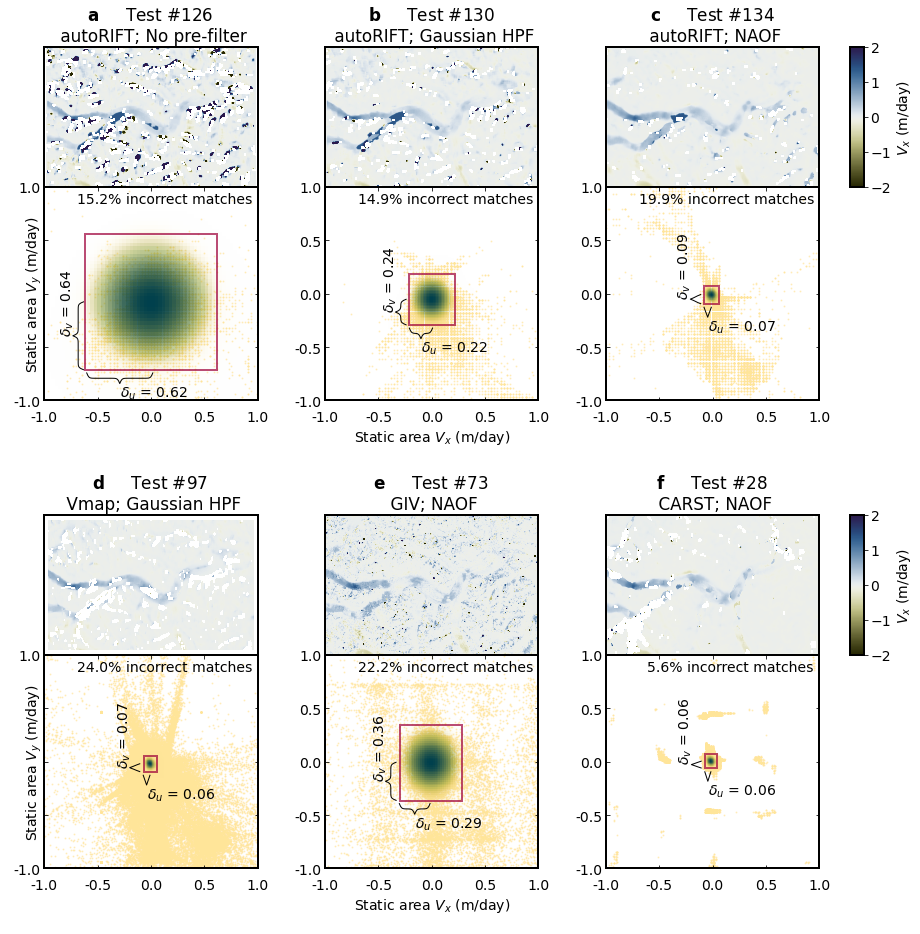

In [5]:
fig = plt.figure(figsize=(13, 13))
subfigs = fig.subfigures(2, 4, wspace=0, hspace=0, width_ratios=(0.3, 0.3, 0.3, 0.1))    # last column is for colorbar
all_axs = np.empty((2,4), dtype='object')

# create two subplots in each subfigure
for i, row in enumerate(subfigs[:, :3]):
    for j, subfig in enumerate(row):
        all_axs[i, j] = subfig.subplots(2, 1, gridspec_kw = {'hspace':0, 'height_ratios':(0.3962, 0.6038)})

title_labels = np.array([['$\mathbf{a}$ \t Test #126 \n autoRIFT; No pre-filter', 
                          '$\mathbf{b}$ \t Test #130 \n autoRIFT; Gaussian HPF', 
                          '$\mathbf{c}$ \t Test #134 \n autoRIFT; NAOF'], 
                         ['$\mathbf{d}$ \t Test #97 \n Vmap; Gaussian HPF', 
                          '$\mathbf{e}$ \t Test #73 \n GIV; NAOF', 
                          '$\mathbf{f}$ \t Test #28 \n CARST; NAOF']])

for idx, i, j in [[126, 0, 0], [130, 0, 1], [134, 0, 2],
                  [97,  1, 0], [73,  1, 1], [28,  1, 2]]:
    exp = exps[idx]
    
    # top panel
    ax_sel = all_axs[i, j][0]
    cm_settings = glaft.show_velocomp(exp.vxfile, ax=ax_sel)
    ax_sel.set_aspect('equal', adjustable='datalim')
    ax_sel.set_title(title_labels[i, j])
    
    # bottom panel
    ax_sel = all_axs[i, j][1]
    exp.plot_zoomed_extent(ax=ax_sel)
    ax_sel.set_aspect('equal', adjustable='box')
    ax_sel.set_xlim(-1, 1)
    ax_sel.set_ylim(-1, 1)
    ax_sel.set_title(None)
    
    # bottom panel ticks
    ax_sel.tick_params(direction="in", bottom=True, top=True, left=True, right=True)
    ax_sel.tick_params(axis='x', pad=10)
    ax_sel.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax_sel.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax_sel.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    ax_sel.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    
    # show percentage of incorrent matches
    ax_sel.text(0.95, 0.95, '{:.1f}% incorrect matches'.format(exp.outlier_percent * 100), ha='right', va='top')
    
    # annotations of du and dv
    draw_brace_x(ax_sel, 
                 xspan=(exp.kdepeak_x - exp.metric_static_terrain_x, exp.kdepeak_x), 
                 yy=exp.kdepeak_y - exp.metric_static_terrain_y, 
                 text='$\delta_u$ = {:.2f}'.format(exp.metric_static_terrain_x))
    draw_brace_y(ax_sel, 
                 yspan=(exp.kdepeak_y - exp.metric_static_terrain_y, exp.kdepeak_y), 
                 xx=exp.kdepeak_x - exp.metric_static_terrain_x, 
                 text='$\delta_v$ = {:.2f}'.format(exp.metric_static_terrain_y))
    

# fine-tune positions of the top panels
bbox_top    = all_axs[0, 0][0].get_position()
bbox_bottom = all_axs[0, 0][1].get_position()
bbox_top.x0 = bbox_bottom.x0
bbox_top.x1 = bbox_bottom.x1
bbox_top.y0 = bbox_bottom.y1
new_bbox_top_y1 = bbox_top.y0 + (bbox_top.y1 - bbox_top.y0) * ((bbox_bottom.x1 - bbox_bottom.x0) / (bbox_top.x1 - bbox_top.x0))
bbox_top.y1 = new_bbox_top_y1

for i, row in enumerate(all_axs[:, :3]):
    for j, subfig in enumerate(row):
        all_axs[i, j][0].set_position(bbox_top)

# add colorbars
mappable = glaft.prep_colorbar_mappable(**cm_settings)
cax = subfigs[0, 3].add_axes([0.0, bbox_top.y0, 0.15, bbox_top.y1 - bbox_top.y0])
subfigs[0, 3].colorbar(mappable, cax=cax, orientation='vertical', label='$V_x$ ({})'.format(exp.velocity_unit), ticks=[-2, -1, 0, 1, 2])
cax = subfigs[1, 3].add_axes([0.0, bbox_top.y0, 0.15, bbox_top.y1 - bbox_top.y0])
subfigs[1, 3].colorbar(mappable, cax=cax, orientation='vertical', label='$V_x$ ({})'.format(exp.velocity_unit), ticks=[-2, -1, 0, 1, 2])

# add axis labels
all_axs[0, 0][1].set_yticklabels(['-1.0', '', '', '', '1.0'])                                      # to prevent label bleeding
all_axs[1, 0][1].set_yticklabels(['-1.0', '', '', '', '1.0'])                                      # ditto
all_axs[0, 0][1].set_ylabel('Static area $V_y$ ({})'.format(exp.velocity_unit), labelpad=-30.0)    # ditto
all_axs[1, 0][1].set_ylabel('Static area $V_y$ ({})'.format(exp.velocity_unit), labelpad=-30.0)    # ditto

all_axs[0, 1][1].set_xlabel('Static area $V_x$ ({})'.format(exp.velocity_unit))
all_axs[1, 1][1].set_xlabel('Static area $V_x$ ({})'.format(exp.velocity_unit))

# save figure
fig.patch.set_facecolor('xkcd:white')
fig.savefig('Fig2.png', dpi=200)